# NYC Property Sales Analysis
This notebook analyzes NYC Property Sales data. It includes data cleaning, visualization, and exploration of the relationships between `SALE PRICE` and other features. Reference: ChatGPT

In [57]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

%matplotlib inline

## Load and Clean Data

In [58]:
# Define correct column names
column_names = [
    "BOROUGH", "NEIGHBORHOOD", "BUILDING CLASS CATEGORY", 
    "TAX CLASS AT PRESENT", "BLOCK", "LOT", "EASE-MENT", 
    "BUILDING CLASS AT PRESENT", "ADDRESS", "APARTMENT NUMBER", 
    "ZIP CODE", "RESIDENTIAL UNITS", "COMMERCIAL UNITS", 
    "TOTAL UNITS", "LAND SQUARE FEET", "GROSS SQUARE FEET", 
    "YEAR BUILT", "TAX CLASS AT TIME OF SALE", 
    "BUILDING CLASS AT TIME OF SALE", "SALE PRICE", "SALE DATE"
]

# Step 1: Read CSV file with defined column names
file_path = os.path.join(os.getcwd(), "data", "nyc-rolling-sales.csv")
data = pd.read_csv(
    file_path,
    sep=",",
    quotechar='"',
    names=column_names,
    skiprows=1,
    na_values=[" - "],
    on_bad_lines="skip",
    encoding="utf-8"
)

# Step 2: Convert numeric columns to appropriate data types
numeric_columns = [
    "SALE PRICE", "LAND SQUARE FEET", "GROSS SQUARE FEET", 
    "RESIDENTIAL UNITS", "COMMERCIAL UNITS", "TOTAL UNITS"
]
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors="coerce")

# Step 3: Drop rows with invalid or missing `SALE PRICE`
data = data[data["SALE PRICE"] > 0]

# Step 4: Parse and standardize `SALE DATE`
data["SALE DATE"] = pd.to_datetime(data["SALE DATE"], errors="coerce")

# Step 5: Drop rows with invalid dates
data = data.dropna(subset=["SALE DATE"])

# Step 6: Reset the index
data = data.reset_index(drop=True)


C:\Users\or\AppData\Local\Temp\ipykernel_59424\2413175069.py:37: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data["SALE DATE"] = pd.to_datetime(data["SALE DATE"], errors="coerce")


## Part 2: Visualizations

1) Distribution of Sale Prices by Range: A bar chart is used to show the frequency distribution of properties and helps identify the concentration of property sales. It allows us to quickly realize that the lower the price, the higher the frequency.

C:\Users\or\AppData\Local\Temp\ipykernel_59424\2167241841.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='SALE PRICE RANGE', data=data, palette='Blues_r')


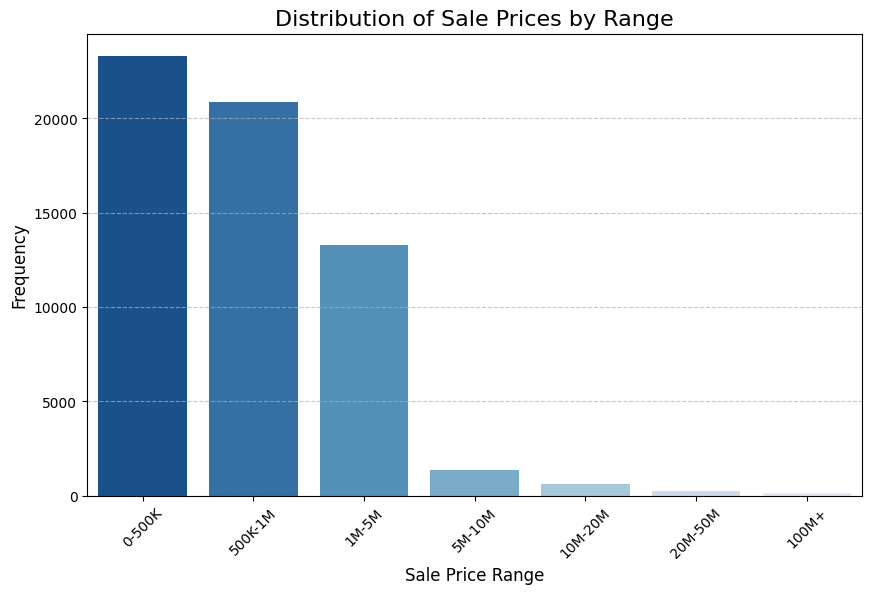

In [59]:
bins = [0, 500000, 1000000, 5000000, 10000000, 20000000, 50000000, 1000000000]  # Custom price ranges
labels = ['0-500K', '500K-1M', '1M-5M', '5M-10M', '10M-20M', '20M-50M', '100M+']

# Create a new column for binned sale prices
data['SALE PRICE RANGE'] = pd.cut(data['SALE PRICE'], bins=bins, labels=labels, include_lowest=True)

# Plot the count of properties in each range
plt.figure(figsize=(10, 6))
sns.countplot(x='SALE PRICE RANGE', data=data, palette='Blues_r')
plt.title("Distribution of Sale Prices by Range", fontsize=16)
plt.xlabel("Sale Price Range", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

2) Average Sale Price by Year Built: A line plot is used to track the trend of average sale prices over time as related to the year properties were built. It gives us another perspective of why some properties might have different prices, as it appears on the graph, the older it is, roughly the more it costs.

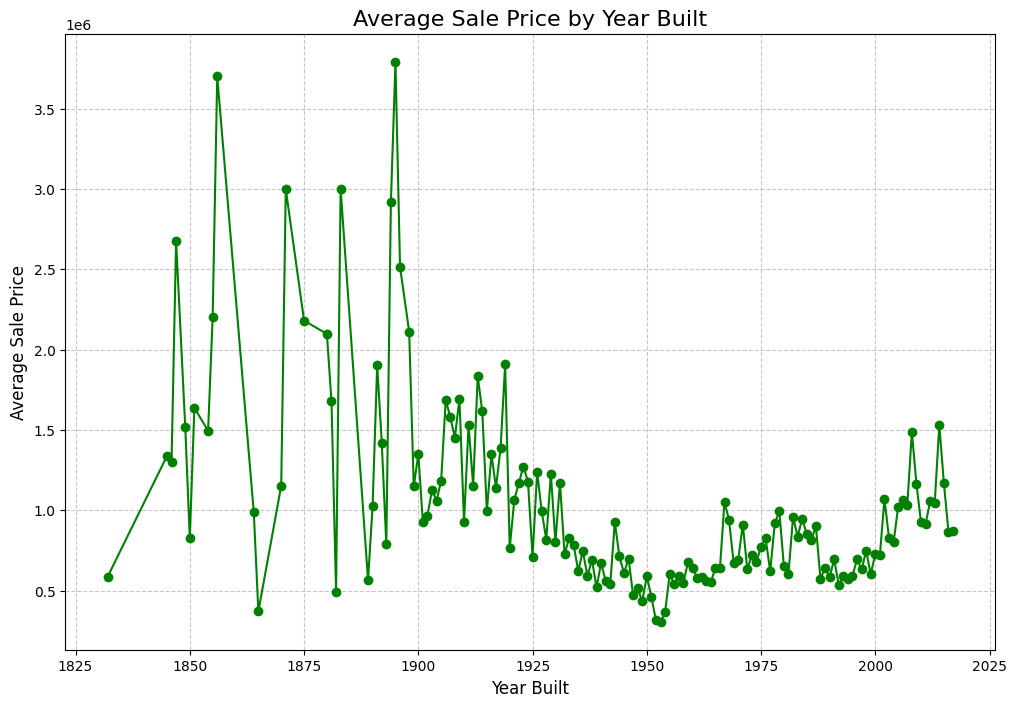

In [60]:
filtered_data = data[
    (data["SALE PRICE"] <= 5_000_000) & 
    (data["SALE PRICE"] > 0) & 
    (data["YEAR BUILT"] > 1800)
]
# Calculate the average sale price by year built
average_price_by_year = filtered_data.groupby("YEAR BUILT")["SALE PRICE"].mean()

# Line plot for Average Sale Price by Year Built
plt.figure(figsize=(12, 8))
plt.plot(
    average_price_by_year.index, 
    average_price_by_year.values, 
    marker="o", 
    color="green"
)
plt.title("Average Sale Price by Year Built", fontsize=16)
plt.xlabel("Year Built", fontsize=12)
plt.ylabel("Average Sale Price", fontsize=12)
plt.grid(axis="both", linestyle="--", alpha=0.7)
plt.show()


3) Distribution of Sale Price Ranges by Borough: A grouped bar chart breaks down the count of properties into price ranges for each borough, providing a comparative view. It indicates wealth concentrations, which means for each borough, we are able to see the dominating price ranges, and compare different borough with consideration of property count.

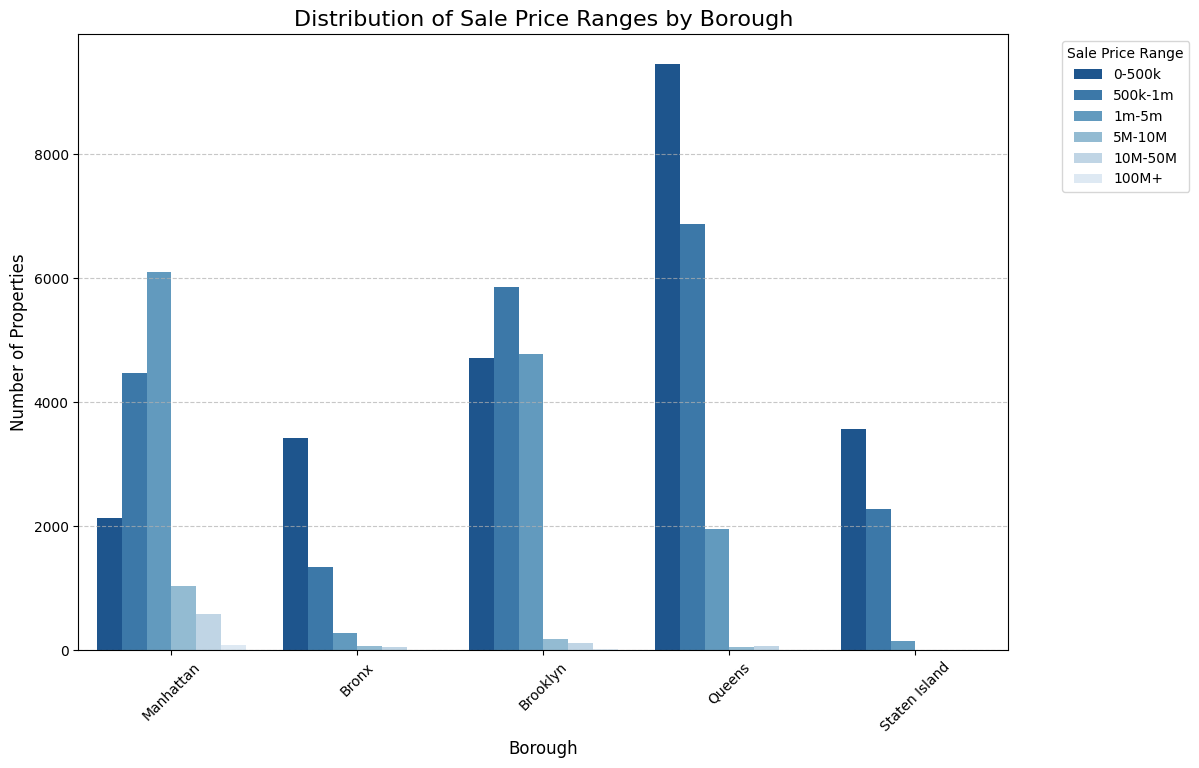

In [61]:
# Create bins for sale price ranges
bins = [0, 500000, 1000000, 5000000, 10000000, 50000000, float("inf")]
labels = ['0-500k', '500k-1m', '1m-5m', '5M-10M', '10M-50M', '100M+']

# Assign each sale price to a bin
data['SALE PRICE RANGE'] = pd.cut(data['SALE PRICE'], bins=bins, labels=labels, include_lowest=True)

# Replace numbers in the BOROUGH column with borough names
borough_mapping = {
    1: "Manhattan",
    2: "Bronx",
    3: "Brooklyn",
    4: "Queens",
    5: "Staten Island"
}
data["BOROUGH"] = data["BOROUGH"].map(borough_mapping)

# Plot: Count of properties by price range for each borough
plt.figure(figsize=(12, 8))
sns.countplot(x='BOROUGH', hue='SALE PRICE RANGE', data=data, palette='Blues_r')
plt.title("Distribution of Sale Price Ranges by Borough", fontsize=16)
plt.xlabel("Borough", fontsize=12)
plt.ylabel("Number of Properties", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Sale Price Range", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


4) Gross Square Feet vs. Sale Price: A scatterplot is ideal for examining the relationship between two continuous variables, It visually demonstrates the correlation between property size and price, helping identify outliers like underpriced large properties or overpriced small ones.

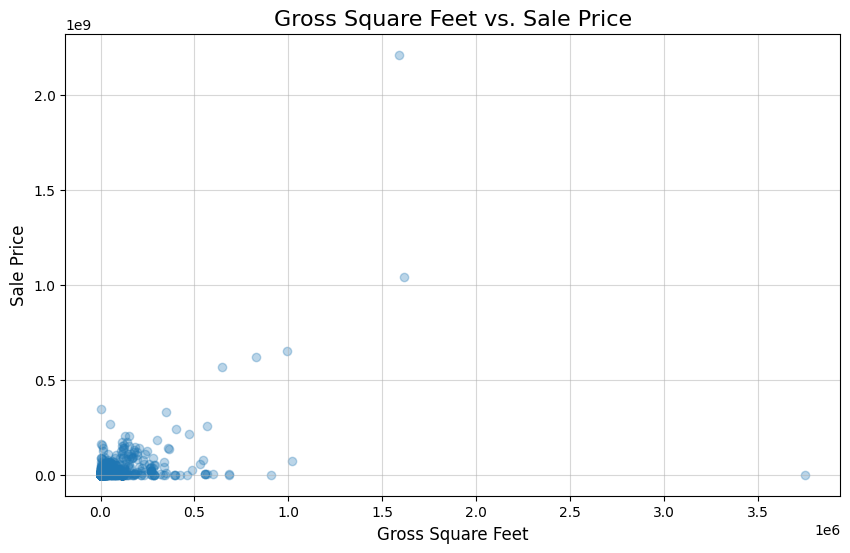

In [62]:
plt.figure(figsize=(10, 6))
plt.scatter(data['GROSS SQUARE FEET'], data['SALE PRICE'], alpha=0.3)
plt.title('Gross Square Feet vs. Sale Price', fontsize=16)
plt.xlabel('Gross Square Feet', fontsize=12)
plt.ylabel('Sale Price', fontsize=12)
plt.grid(alpha=0.5)
plt.show()

5) Correlation Heatmap: A heatmap provides an intuitive view of correlations between numerical features, making it easy to identify strong or weak relationships. Indicates which features are most influential on sale price, guiding feature selection for predictive models. Keep in mind that the correlation is symmetric.

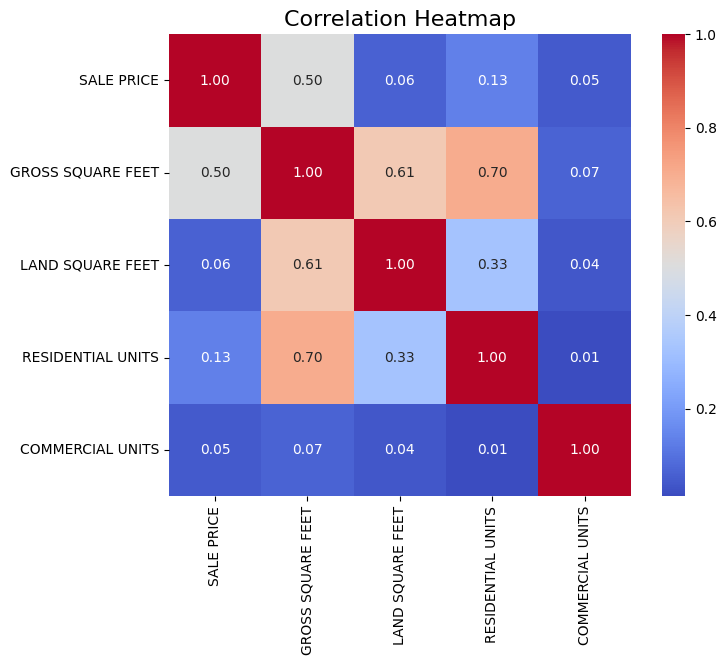

In [63]:
correlation_matrix = data[["SALE PRICE", "GROSS SQUARE FEET", "LAND SQUARE FEET", "RESIDENTIAL UNITS", "COMMERCIAL UNITS"]].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

## Part 3: Basic Pipeline Model

MAE: 249081.07
RMSE: 348522.86
R²: 0.38


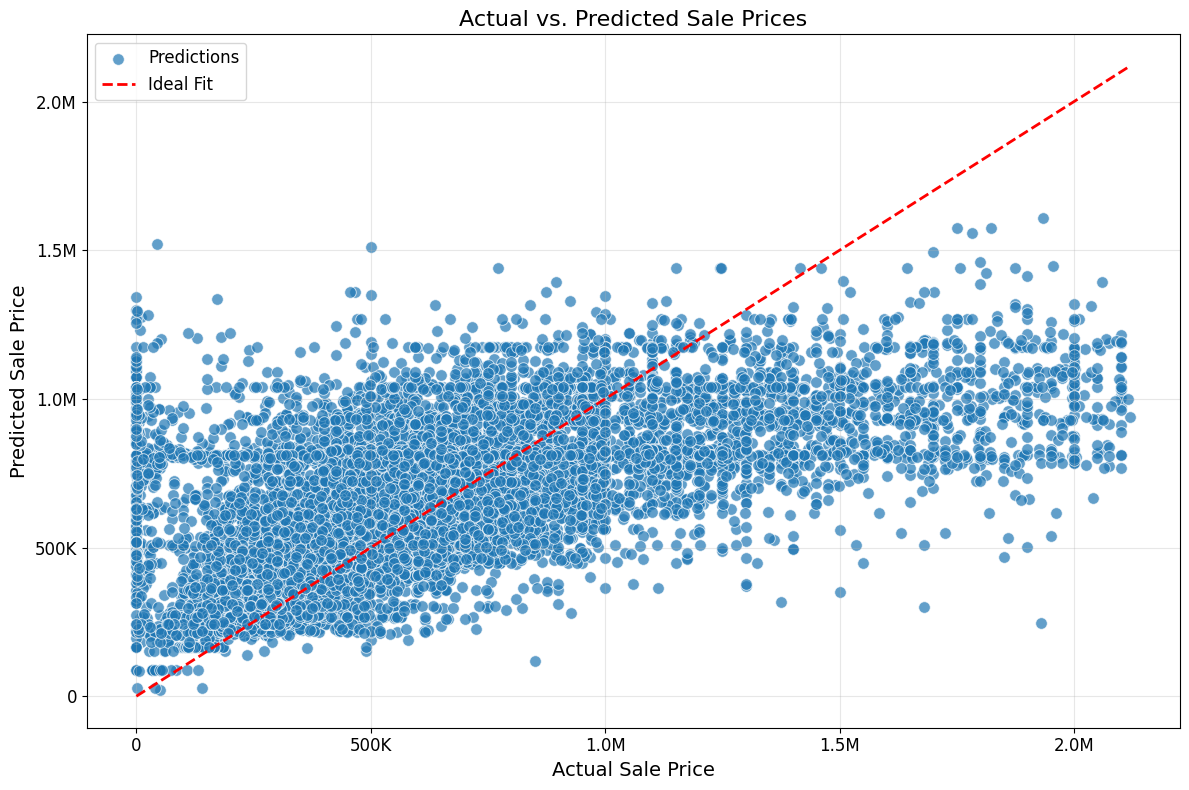

In [64]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

# 2. Preprocessing
# Fill missing values for numeric columns
numeric_columns = data.select_dtypes(include=["number"]).columns
for col in numeric_columns:
    data[col] = data[col].fillna(data[col].median())

# Label encode the BOROUGH column
label_encoder = LabelEncoder()  # Initialize the LabelEncoder
data["BOROUGH"] = label_encoder.fit_transform(data["BOROUGH"])  # Apply Label Encoding

# Define features and target variable
features = [
    "BOROUGH", "LAND SQUARE FEET", "TOTAL UNITS", "YEAR BUILT", "GROSS SQUARE FEET"
]
X = data[features]  # Select features
y = data["SALE PRICE"]  # Target variable
# 3. Remove Outliers Using IQR

Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_filter = (y >= lower_bound) & (y <= upper_bound)
X = X[outlier_filter]
y = y[outlier_filter]

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Train XGBoost Regressor
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(X_train, y_train)

# 5. Predict and Evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# 6. Actual vs Predicted Sale Prices
# Function to format axis labels as K (thousands) or M (millions)
def format_ticks(value, _):
    if value >= 1_000_000:
        return f'{value/1_000_000:.1f}M'
    elif value >= 10_000:
        return f'{value/1_000:.0f}K'
    else:
        return f'{value:.0f}'

# Plot Actual vs. Predicted Sale Prices
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test, y=y_pred, s=70, alpha=0.7, label="Predictions")
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         color='red', linestyle='--', linewidth=2, label="Ideal Fit")

# Add labels and titles
plt.title("Actual vs. Predicted Sale Prices", fontsize=16)
plt.xlabel("Actual Sale Price", fontsize=14)
plt.ylabel("Predicted Sale Price", fontsize=14)

# Format axes with custom tick labels
plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Improve layout and add grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


## Part 4: Error Analysis

The worst predictions could appear because of outlier cases such as unusual features, extreme sale prices, sparse data for certain categories, quality issues like incorrect records, or the fact that the prediction does not capture all influential variables, like renovation status or property demand trends. The result contains a value of 10 in the "actual" colomn is a good example of a strange record which throws the prediction off.

The best predictions could appear because these cases represent properties falling within the typical range of sale prices and features that the model has seen frequently during training (like overfitting). Alternatively, larger sale prices might have larger errors.

Worst Predictions
          Actual     Predicted  Absolute Error         Error
28150  1930000.0  2.462351e+05    1.683765e+06  1.683765e+06
16009    43000.0  1.522331e+06    1.479331e+06 -1.479331e+06
23754  1950000.0  5.402108e+05    1.409789e+06  1.409789e+06
32202  1900000.0  5.025812e+05    1.397419e+06  1.397419e+06
16990  1850000.0  4.677560e+05    1.382244e+06  1.382244e+06
47459  1680000.0  3.011770e+05    1.378823e+06  1.378823e+06
15713  2040000.0  6.661821e+05    1.373818e+06  1.373818e+06
47057  1962500.0  6.157861e+05    1.346714e+06  1.346714e+06
31505       10.0  1.342499e+06    1.342489e+06 -1.342489e+06
34676  2100000.0  7.684922e+05    1.331508e+06  1.331508e+06

Best Predictions
          Actual     Predicted  Absolute Error       Error
18791   449000.0  4.490027e+05        2.718750   -2.718750
46749  1080000.0  1.080023e+06       23.000000  -23.000000
50145   491416.0  4.913919e+05       24.093750   24.093750
55748   550000.0  5.499682e+05       31.812500   31.81250

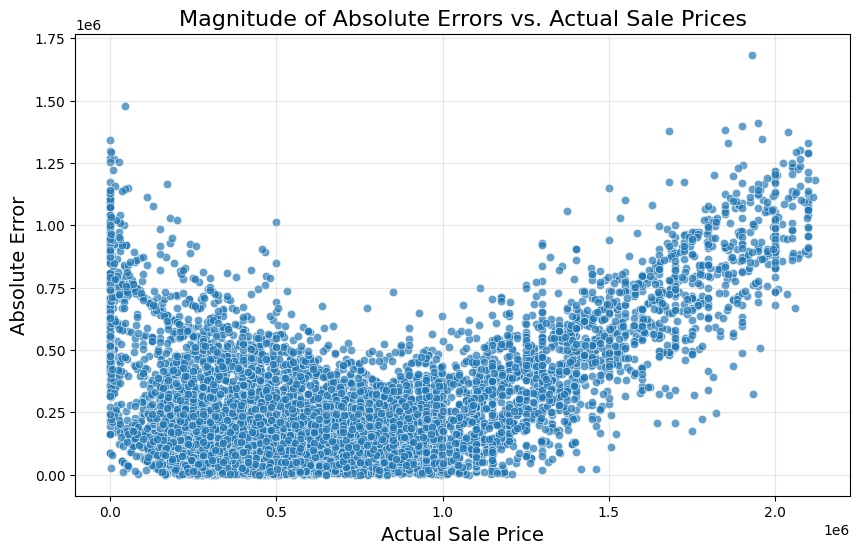

In [65]:
# Create a DataFrame of errors
errors = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Absolute Error": np.abs(y_test - y_pred),
    "Error": y_test - y_pred  # Positive: Overestimation, Negative: Underestimation
})

# Worst Predictions (Top 10 highest absolute errors)
worst_predictions = errors.sort_values(by="Absolute Error", ascending=False).head(10)
print("Worst Predictions")
print(worst_predictions)

# Best Predictions (Top 10 lowest absolute errors)
best_predictions = errors.sort_values(by="Absolute Error", ascending=True).head(10)
print("\nBest Predictions")
print(best_predictions)

# Scatterplot of Actual vs Absolute Error
plt.figure(figsize=(10, 6))
sns.scatterplot(x=errors["Actual"], y=errors["Absolute Error"], alpha=0.7)
plt.title("Magnitude of Absolute Errors vs. Actual Sale Prices", fontsize=16)
plt.xlabel("Actual Sale Price", fontsize=14)
plt.ylabel("Absolute Error", fontsize=14)
plt.grid(alpha=0.3)
plt.show()

Overestimations and underestimations in the model arise from limitations in the data, such as skewed distributions, missing features, and outliers. Factors like unaccounted neighborhood trends, unique property characteristics, or market dynamics can also lead to inaccuracies. These issues are compounded by noise or errors in the dataset, such as inconsistent or incorrect entries.

Top 5 Overestimations:
        Actual    Predicted     Residual
16009  43000.0  1522331.000 -1479331.000
31505     10.0  1342499.250 -1342489.250
7464      10.0  1299513.375 -1299503.375
27593   1000.0  1295426.375 -1294426.375
50000     10.0  1268419.250 -1268409.250
Top 5 Underestimations:
          Actual      Predicted      Residual
47459  1680000.0  301176.968750  1.378823e+06
16990  1850000.0  467756.000000  1.382244e+06
32202  1900000.0  502581.156250  1.397419e+06
23754  1950000.0  540210.812500  1.409789e+06
28150  1930000.0  246235.078125  1.683765e+06


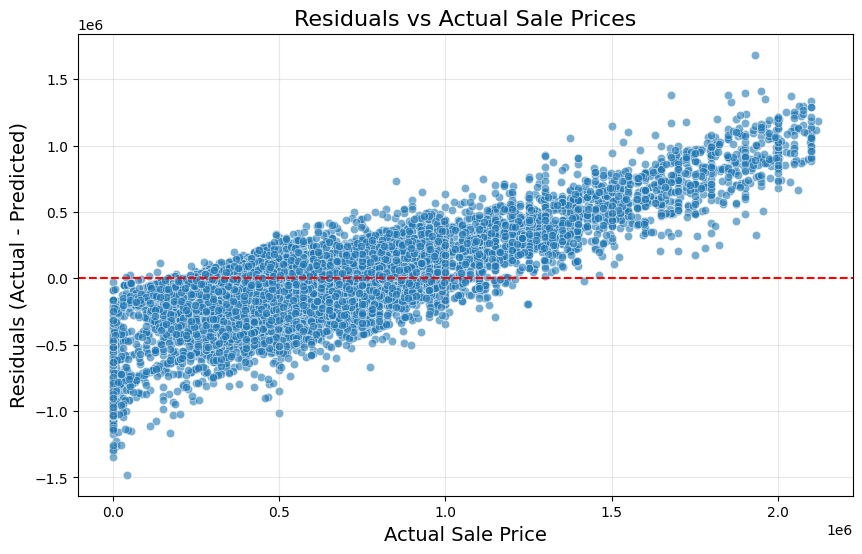

In [66]:
# Residuals
residuals = y_test - y_pred

# Worst and Best Performing Predictions
worst_predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Residual': residuals})
worst_predictions = worst_predictions.sort_values(by='Residual', ascending=True)  # Largest negative residuals (worst)

# Top 5 Overestimations
print("Top 5 Overestimations:")
print(worst_predictions.head())

# Top 5 Underestimations
print("Top 5 Underestimations:")
print(worst_predictions.tail())


# Scatter plot of residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Actual Sale Prices", fontsize=16)
plt.xlabel("Actual Sale Price", fontsize=14)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=14)
plt.grid(alpha=0.3)
plt.show()


As it seems in the heatmap there are low correlations between the features, which indicates that errors are not strongly associated with any single feature, except the 0.78 correlation which is indicating potential multicollinearity in the data. While this doesn’t directly affect the errors, it could influence the model's interpretation of these features.

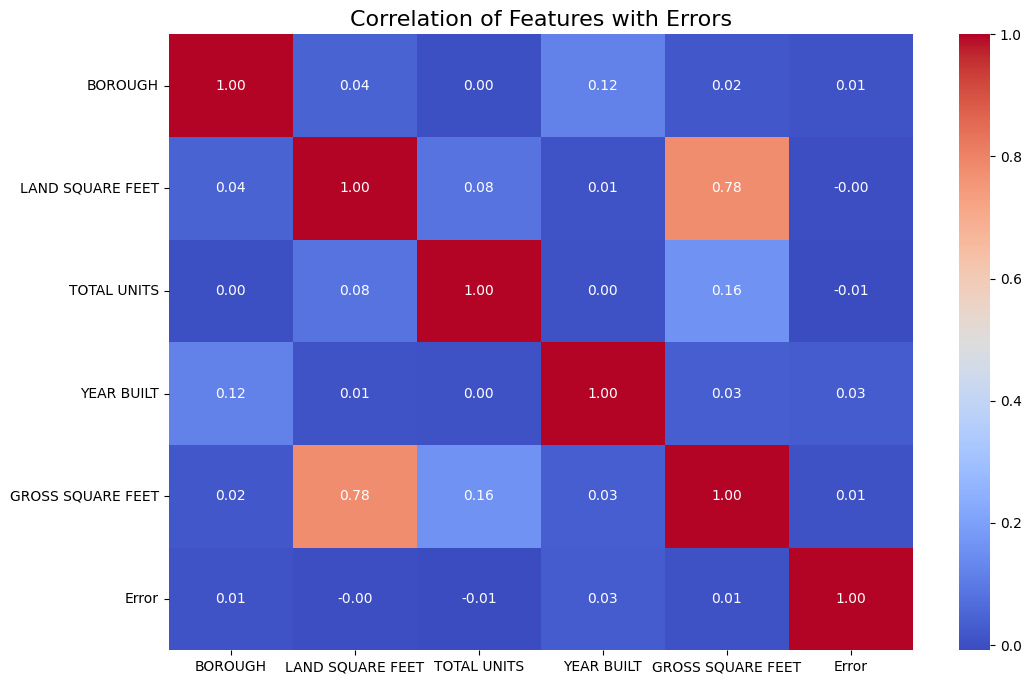

In [67]:
# Combine errors with test features
test_data = X_test.copy()
test_data["Error"] = residuals

# Heatmap to explore correlation between errors and features
plt.figure(figsize=(12, 8))
sns.heatmap(test_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation of Features with Errors", fontsize=16)
plt.show()



Some potential sabotages of features could be sale prices that are being misrepresented for tax or other reporting purposes. In addition, extreme values of sale prices or other features might disproportionately affect model training and predictions. According to the following graph, there are features that are considered more important than the other in the data capturing, therefore, they could cause greater sabotages, for example, a certain borough with many records could affect the overall statistics.

C:\Users\or\AppData\Local\Temp\ipykernel_59424\3865960512.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")


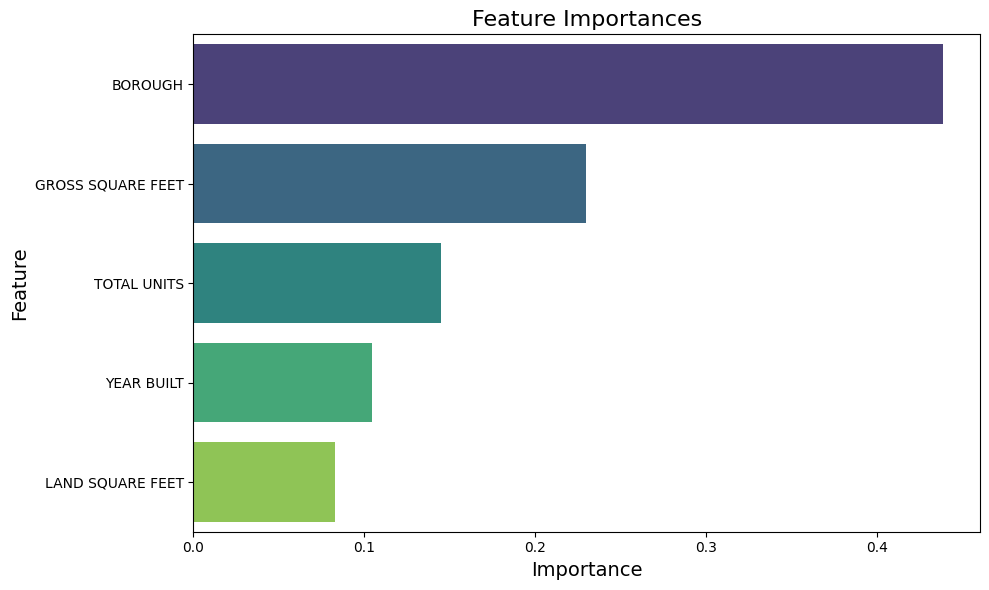

In [68]:
# Get feature importances
importance = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
plt.title('Feature Importances', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()


The distribution of residuals provides insight into the accuracy and bias of the model's predictions. The normal distribution is ideal due to errors being random and true. The slight asymmetry to the left indicates that it is just a little unbias towards underestimations. A mean close to zero suggests that the model's predictions are, on average, accurate.

Mean Residual: -943.26


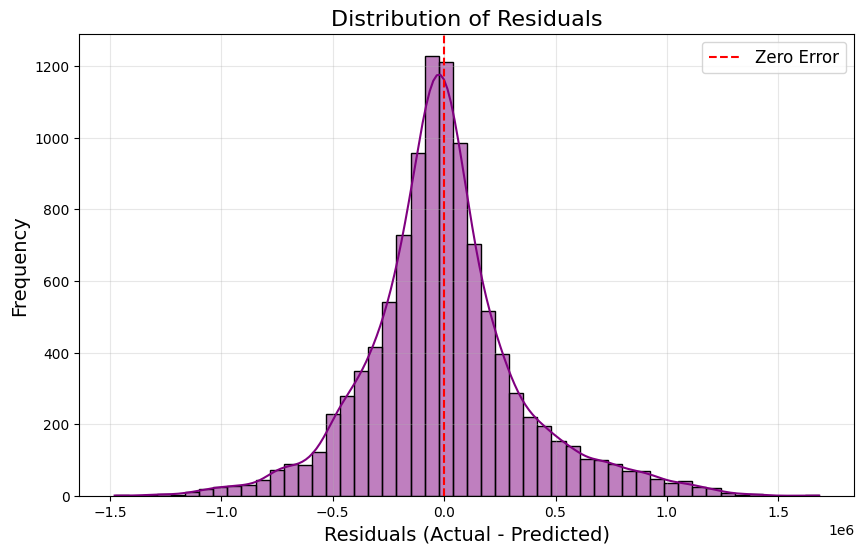

In [69]:
# Mean of residuals
mean_residual = residuals.mean()
print(f"Mean Residual: {mean_residual:.2f}")

# Visualization of residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50, color='purple')
plt.axvline(0, color='red', linestyle='--', label="Zero Error")
plt.title("Distribution of Residuals", fontsize=16)
plt.xlabel("Residuals (Actual - Predicted)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()


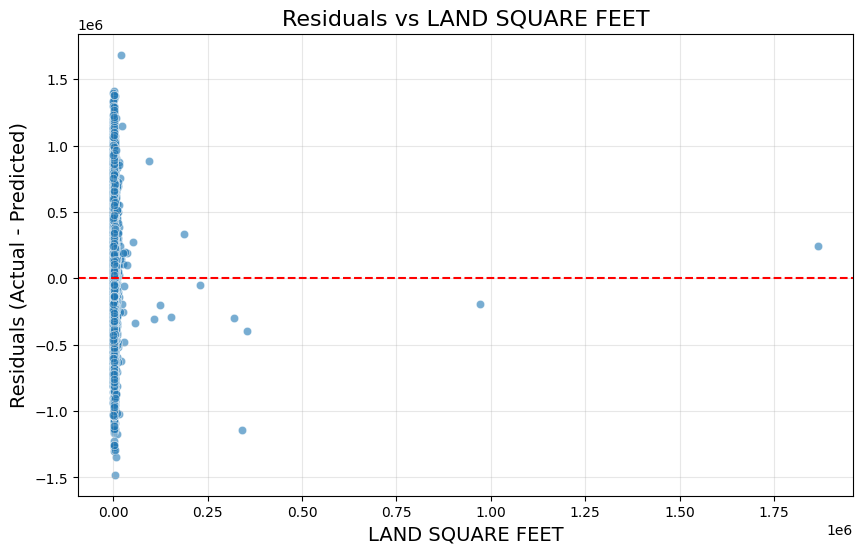

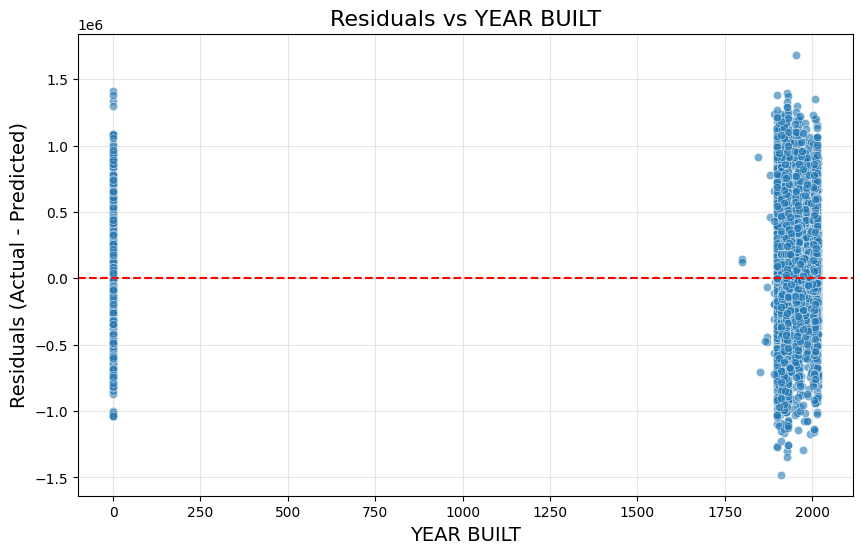

In [70]:
# Residuals vs. Key Features
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['LAND SQUARE FEET'], y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs LAND SQUARE FEET", fontsize=16)
plt.xlabel("LAND SQUARE FEET", fontsize=14)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=14)
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test['YEAR BUILT'], y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs YEAR BUILT", fontsize=16)
plt.xlabel("YEAR BUILT", fontsize=14)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=14)
plt.grid(alpha=0.3)
plt.show()
